In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
DATA_DIR = Path().cwd().parent / 'data'

In [3]:
assert DATA_DIR.exists()

# Read in .TRM files

In [4]:
dfs = [pd.read_csv(filename) for filename in DATA_DIR.glob('*.TRM')]

In [5]:
len(dfs)

200

In [40]:
# for df in dfs:
#     print(df.head())

In [6]:
df = dfs[0]

In [7]:
df.head()

,File: Users\stell\Desktop\StellarDat\Hampton E\r\n TRANS-> Wave:2830.74nm Pix:1050 Val:-1139.423 Time: 35ms Avg:10 Sm:2 Sg:0 Tc:off SNAP Xt:3 Ch:1 Xtrig
0,862.13 1.0000E-003
1,863.88 1.0000E-003
2,865.63 1.0000E-003
3,867.38 -1.0782E+002
4,869.13 -3.9562E+002


## extract the header information

In [8]:
info = df.columns[0]

## extract the time series info

In [9]:
data = df.iloc[:,0]

In [10]:
data

0        862.13  1.0000E-003
1        863.88  1.0000E-003
2        865.63  1.0000E-003
3       867.38  -1.0782E+002
4       869.13  -3.9562E+002
               ...          
505     1745.88  5.2803E+001
506     1747.63  5.2860E+001
507     1749.38  5.2929E+001
508     1751.13  5.2994E+001
509     1752.88  5.3099E+001
Name:  File: Users\stell\Desktop\StellarDat\Hampton E\r\n  TRANS->  Wave:2830.74nm  Pix:1050  Val:-1139.423  Time: 35ms  Avg:10  Sm:2  Sg:0  Tc:off  SNAP  Xt:3  Ch:1  Xtrig  , Length: 510, dtype: object

## get number of steps in time series

In [11]:
len(data)

510

## remove whitespace

In [12]:
data = data.str.strip()

## split columns on space

In [13]:
data = data.str.partition(' ')

In [14]:
data.head()

,0,1,2
0,862.13,,1.0000E-003
1,863.88,,1.0000E-003
2,865.63,,1.0000E-003
3,867.38,,-1.0782E+002
4,869.13,,-3.9562E+002


## get first column as wavelengths

In [15]:
wavelengths = data[0]
wavelengths.head()

0    862.13
1    863.88
2    865.63
3    867.38
4    869.13
Name: 0, dtype: object

## convert wavelengths to float (decimal numbers)

In [16]:
wavelengths = wavelengths.astype(float)
wavelengths.head()

0    862.13
1    863.88
2    865.63
3    867.38
4    869.13
Name: 0, dtype: float64

In [17]:
wavelengths.describe()

count     510.000000
mean     1307.505000
std       257.895025
min       862.130000
25%      1084.817500
50%      1307.505000
75%      1530.192500
max      1752.880000
Name: 0, dtype: float64

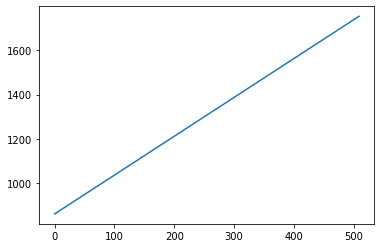

In [18]:
plt.plot(wavelengths)

## extract transmittance

In [19]:
transmittance = data[2]
transmittance.head()

0      1.0000E-003
1      1.0000E-003
2      1.0000E-003
3     -1.0782E+002
4     -3.9562E+002
Name: 2, dtype: object

## convert transmittance to float

In [20]:
transmittance = transmittance.astype(float)

In [21]:
transmittance.head()

0      0.001
1      0.001
2      0.001
3   -107.820
4   -395.620
Name: 2, dtype: float64

In [22]:
transmittance.describe()

count    510.000000
mean      51.587480
std       25.641209
min     -395.620000
25%       43.845500
50%       56.782000
75%       62.150750
max       66.546000
Name: 2, dtype: float64

## remove transmittance values that are less than 0 and corresponding wavelengths

In [23]:
mask = transmittance > 0
transmittance = transmittance[mask]
wavelengths = wavelengths[mask]

In [24]:
# plot transmittance vs wavelength

In [25]:
def plot_sample(wavelengths, transmittance):
    plt.figure(figsize=(20,10))
    plt.title('Transmittance vs Wavelength')
    plt.xlabel('Wavelength(nm)')
    plt.ylabel('Transmittance (counts)')
    plt.plot(wavelengths, transmittance)

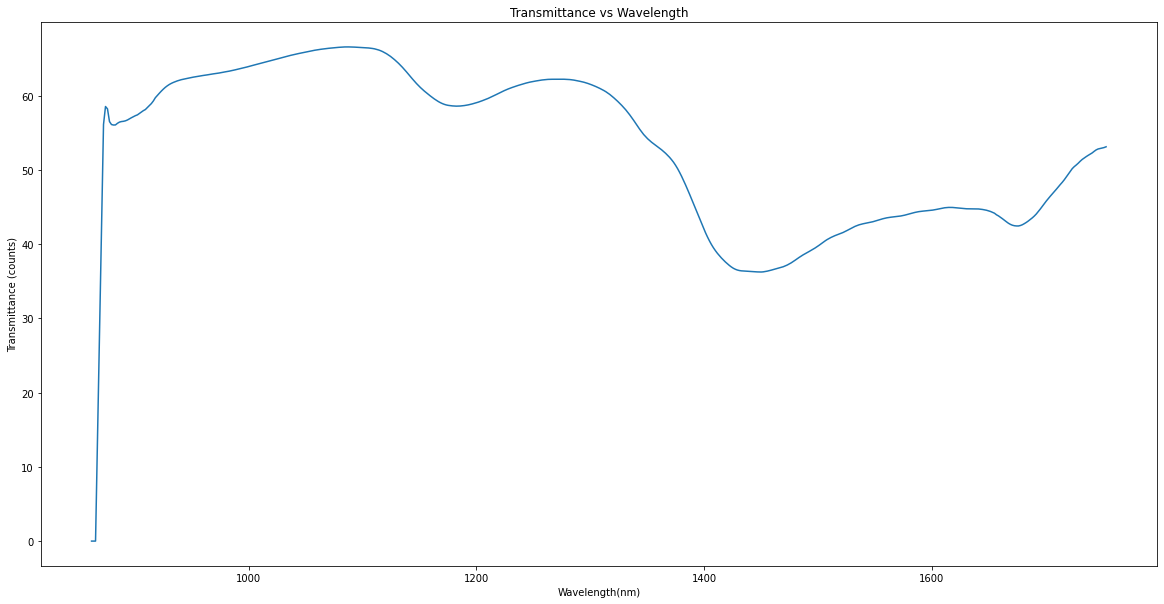

In [26]:
plot_sample(wavelengths, transmittance)

# convert TRM to sample

In [27]:
transmittance

0       0.001
1       0.001
2       0.001
6      56.100
7      58.520
        ...  
505    52.803
506    52.860
507    52.929
508    52.994
509    53.099
Name: 2, Length: 507, dtype: float64

In [28]:
pd.DataFrame([transmittance.values], columns=wavelengths)

,862.13,863.88,865.63,872.63,874.38,876.13,877.88,879.63,881.38,883.13,...,1737.13,1738.88,1740.63,1742.38,1744.13,1745.88,1747.63,1749.38,1751.13,1752.88
0,0.001,0.001,0.001,56.1,58.52,58.199,56.492,56.092,56.027,56.041,...,51.943,52.097,52.268,52.482,52.676,52.803,52.86,52.929,52.994,53.099


In [29]:
def _extract_trm_filename_info(filename):
    sample_name_method, _, _ = filename.partition('-')
    if '(' in sample_name_method:
        sample_name, _, process_method = sample_name_method.partition('(')
        sample_name = sample_name.strip()
        process_method = process_method.strip()[:-1] # drop )
    else:
        sample_name = sample_name_method.strip()
        process_method = ''
    sample_date = pd.to_datetime(filename.partition('-')[2].partition('#')[0])
    run_number = filename.partition('#')[2].partition('.')[0]
    return sample_name, process_method, sample_date, run_number

In [57]:
def parse_trm(trm_path, drop_neg_trans=False):
    trm_path = Path(trm_path)
    df = pd.read_csv(trm_path)
    extra_info = df.columns[0]
    data = df.iloc[:,0]\
             .str.strip()\
             .str.partition(' ')
    wavelengths = data[0].astype(float)
    transmittance = data[2].astype(float)
    if drop_neg_trans:
        mask = transmittance > 0
        transmittance = transmittance[mask]
        wavelengths = wavelengths[mask]
    sample_df = pd.DataFrame([transmittance.values], columns=wavelengths)
    sample_df['extra_info'] = extra_info
    sample_df['filename'] = trm_path.name
    sample_name, process_method, sample_date, run_number = _extract_trm_filename_info(trm_path.name)
    sample_df['sample_name'] = sample_name
    sample_df['sample_date'] = sample_date
    sample_df['run_number'] = run_number
    sample_df['process_method'] = process_method
    return sample_df

In [58]:
def parse_trms(trm_directory):
    trm_directory = Path(trm_directory)
    return pd.concat([parse_trm(trm_filepath) for trm_filepath in trm_directory.glob("*.TRM")])

In [59]:
df_trms = parse_trms(DATA_DIR)

In [60]:
len(df_trms)

200

In [64]:
num = df_trms._get_numeric_data()

In [66]:
num[num < 0] = 0

In [67]:
num = df_trms._get_numeric_data()

In [71]:
num[num < 0]

,862.13,863.88,865.63,867.38,869.13,870.88,872.63,874.38,876.13,877.88,...,1737.13,1738.88,1740.63,1742.38,1744.13,1745.88,1747.63,1749.38,1751.13,1752.88
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# check for null values

In [69]:
df_trms.isnull()

,862.13,863.88,865.63,867.38,869.13,870.88,872.63,874.38,876.13,877.88,...,1747.63,1749.38,1751.13,1752.88,extra_info,filename,sample_name,sample_date,run_number,process_method
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
